In [5]:
import numpy as np
import pandas as pd
import datetime as dt

from power.ml_ops.data import clean_pv_data, get_pv_data

from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers, optimizers

import matplotlib.pyplot as plt

In [ ]:
pv_raw_data = get_pv_data()
pv_df = clean_pv_data(pv_raw_data)
pv_df.rename(columns={'electricity': 'power'}, inplace=True)
pv_df.head(3)

In [12]:
# Temporary

pv_raw_data = pd.read_csv('../raw_data/1980-2022_pv.csv')

pv_df = pv_raw_data.drop(columns=[
                    'irradiance_diffuse',
                    'source',
                    'Unnamed: 0.1'])

# convert dtypes
pv_df.electricity = pv_df.electricity.astype(float)


# pd.to_datetime gives warning
pv_df.local_time = pv_df.local_time.apply(lambda x:
                                        dt.datetime.strptime(x,
                                        "%Y-%m-%d %H:%M:%S%z"))

pv_df['Unnamed: 0'] = pd.to_datetime(pv_df['Unnamed: 0'], unit='ms').dt.tz_localize('UTC')

# correct column names
pv_df.rename(columns={'Unnamed: 0': 'utc_time', 'electricity': 'power'}, inplace=True)

pv_df = pv_df[['utc_time', 'local_time', 'irradiance_direct', 'temperature', 'power']]

pv_df.head(3)

,utc_time,local_time,irradiance_direct,temperature,power
0,1980-01-01 00:00:00+00:00,1980-01-01 01:00:00+01:00,0.0,-1.296,0.0
1,1980-01-01 01:00:00+00:00,1980-01-01 02:00:00+01:00,0.0,-1.216,0.0
2,1980-01-01 02:00:00+00:00,1980-01-01 03:00:00+01:00,0.0,-1.005,0.0


In [13]:
train = pv_df[pv_df['utc_time'] < '2020-01-01']
test = pv_df[pv_df['utc_time'] >= '2020-01-01']

In [14]:
print(len(train))
print(len(test))

350640
26304


In [15]:
train = train[['irradiance_direct', 'temperature', 'power']]
test = test[['irradiance_direct', 'temperature', 'power']]

In [17]:
def get_Xi_yi(
    fold:pd.DataFrame,
    input_length:int,       # 48
    output_length:int,      # 24
    gap_hours):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    - TARGET is the variable(s) we want to predict (name of the column(s))
    '''
    TARGET = 'power'
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + gap_hours + output_length) + 1

    random_start = np.random.randint(first_possible_start, last_possible_start)

    input_start = random_start
    input_end = random_start + input_length
    target_start = input_end + gap_hours
    target_end = target_start + output_length

    X_i = fold.iloc[input_start:input_end]
    y_i = fold.iloc[target_start:target_end][[TARGET]]    # creates a pd.DataFrame for the target y

    return (X_i, y_i)

def get_X_y_seq(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int,
    gap_hours=12):
    '''
    Given a fold, it creates a series of sequences randomly
    as many as being specified
    '''

    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length, gap_hours)   # calls the previous function to generate sequences X + y
        X.append(Xi)
        y.append(yi)

    return np.array(X), np.array(y)


In [18]:
X_train, y_train = get_X_y_seq(train, number_of_sequences=10_000, input_length=48, output_length=24)

In [19]:
X_test, y_test = get_X_y_seq(test, number_of_sequences=1_000, input_length=48, output_length=24)

In [20]:
X_train.shape, y_train.shape

((10000, 48, 3), (10000, 24, 1))

In [21]:
X_test.shape, y_test.shape

((1000, 48, 3), (1000, 24, 1))

In [22]:
def init_model(X_train, y_train, n_unit=24, learning_rate=0.02):


    # 1 - RNN architecture
    # ======================
    model = models.Sequential()

    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(n_unit,
                          activation='tanh',
                          return_sequences = False,
                          input_shape=(X_train.shape[1],X_train.shape[2])
                          ))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================

    def r_squared(y_true, y_pred):
        ss_res = K.sum(K.square(y_true - y_pred))
        ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
        return (1 - ss_res/(ss_tot + K.epsilon()))

    adam = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=adam, metrics=['mae', r_squared])

    return model

In [23]:
model = init_model(X_train, y_train)
model.summary()

2024-03-08 10:57:29.802491: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-08 10:57:29.804494: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24)                2688      
                                                                 
 dense (Dense)               (None, 24)                600       
                                                                 
Total params: 3,288
Trainable params: 3,288
Non-trainable params: 0
_________________________________________________________________


2024-03-08 10:57:30.238963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-08 10:57:30.241548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-08 10:57:30.243197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [24]:
es = EarlyStopping(monitor = "val_mae",
                   mode = "min",
                   patience = 5,
                   restore_best_weights = True)
history = model.fit(X_train, y_train,
                    validation_split = 0.3,
                    shuffle = False,
                    batch_size = 32,
                    epochs = 50,
                    callbacks = [es],
                    verbose = 0)

2024-03-08 10:58:09.697244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-08 10:58:09.700138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-08 10:58:09.701852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

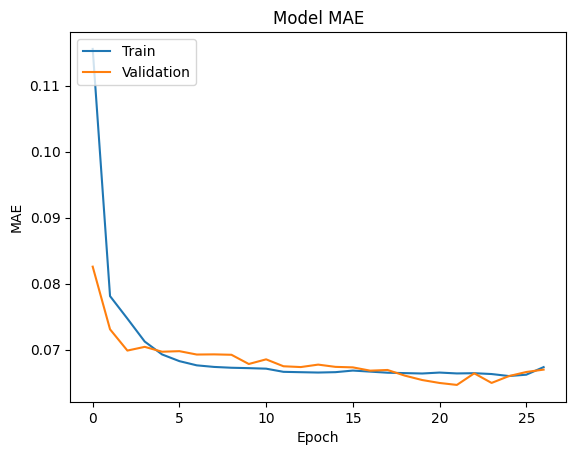

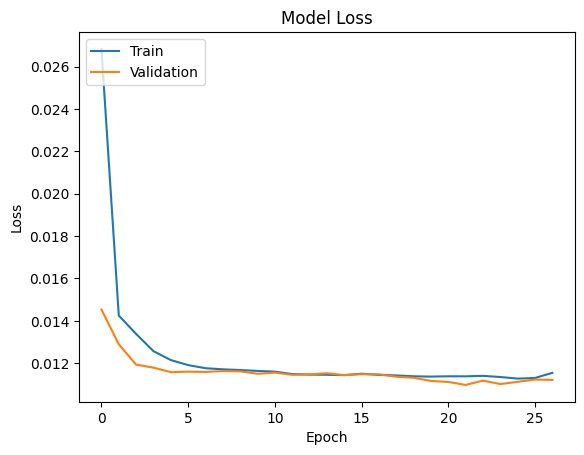

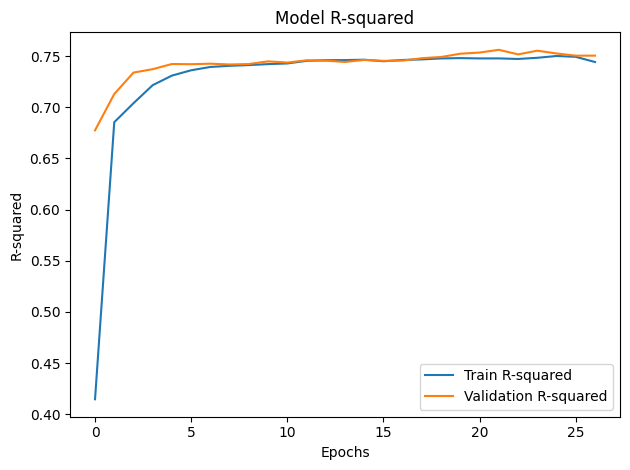

In [25]:
# Plot training & validation MAE values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting R-squared for Train and Validation
#plt.subplot(1, 2, 2)
plt.plot(history.history['r_squared'], label='Train R-squared')
plt.plot(history.history['val_r_squared'], label='Validation R-squared')
plt.title('Model R-squared')
plt.xlabel('Epochs')
plt.ylabel('R-squared')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
res = model.evaluate(X_test, y_test)
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} kW")

32/32 [==============================] - 1s 16ms/step - loss: 0.0110 - mae: 0.0650 - r_squared: 0.7585
The LSTM MAE on the test set is equal to 0.07 kW
